In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.14/09


In [4]:
infile = 'ntuple_SingleMuon_Displaced_2GeV_PhaseIITDRSpring19_add.8.root'

# Takes a collection of events (say, all those with prefix 'vh_') and categorizes them so they are easier to call.
def define_collections(tree):
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return

# Loads the particle gun, which means it loads the tree file and makes the information contained inside easily callable.
def load_pgun():
  print('[INFO] Opening file: %s' % infile)
  global infile_r
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree

def calc_etastar_from_eta(invpt, eta, phi, x0, y0, z0, zstar=850., zstar_4T=650.):
  # Propagate to station 2 (z = 850 cm), find r and eta of the track
  # (called rstar and etastar).
  # Note: x0, y0, z0 in cm. Assume pT -> inf.
  if eta < 0:
    zstar *= -1
  # Assume a simplified magnetic field where it is 4T (or 3.811T)
  # inside the solenoid and 0T outside (boundary at z = 650 cm)
  if eta < 0:
    zstar_4T *= -1
  B = 3.811
  R = -1.0 / (0.003 * B * invpt)  # R = -pT/(0.003 q B)  [cm], radius of the circle
  cot = np.sinh(eta)              # cot(theta), which is pz/pt
  if np.abs(zstar_4T) < np.abs(zstar):
    arg_term_4T = np.abs((zstar_4T - z0)/cot)                 # with magfield
    sin_term_4T = (2 * R) * np.sin(arg_term_4T/(2 * R))       # with magfield
    cos_term_4T = (2 * R) * (1 - np.cos(arg_term_4T/(2 * R))) # with magfield
    arg_term_0T = np.abs((zstar - zstar_4T)/cot)              # without magfield
    sin_term_0T = arg_term_0T                                 # without magfield
    cos_term_0T = 0                                           # without magfield
  else:
    # Also need to check for the boundary at r where 4T -> 0T, ignore for now
    arg_term_4T = np.abs((zstar - z0)/cot)                    # with magfield
    sin_term_4T = (2 * R) * np.sin(arg_term_4T/(2 * R))       # with magfield
    cos_term_4T = (2 * R) * (1 - np.cos(arg_term_4T/(2 * R))) # with magfield
    arg_term_0T = 0                                           # without magfield
    sin_term_0T = 0                                           # without magfield
    cos_term_0T = 0                                           # without magfield
  phistar_4T = phi + arg_term_4T/(2 * R)  # phi at the boundary where 4T -> 0T
  xstar = x0 + np.cos(phi) * sin_term_4T - np.sin(phi) * cos_term_4T + \
          np.cos(phistar_4T) * sin_term_0T - np.sin(phistar_4T) * cos_term_0T
  ystar = y0 + np.sin(phi) * sin_term_4T + np.cos(phi) * cos_term_4T + \
          np.sin(phistar_4T) * sin_term_0T + np.cos(phistar_4T) * cos_term_0T
  rstar = np.hypot(xstar, ystar)
  cotstar = zstar/rstar
  etastar = np.arcsinh(cotstar)
  return etastar

# def calc_signed_rvtx(eta, phi, x0, y0, z0, zstar=850.):
#   # Propagate to station 2 (z = 850 cm)
#   # Note: x0, y0, z0 in cm. Assume pT -> inf.
#   if eta < 0:
#     zstar *= -1
#   cot = np.sinh(eta)
#   delta_r = np.abs((zstar - z0)/cot)
#   xstar = x0 + np.cos(phi) * delta_r
#   ystar = y0 + np.sin(phi) * delta_r
#   rstar = np.hypot(xstar, ystar)
#   rvtx = np.hypot(x0, y0)
#   if (rstar - delta_r) <= 0.:
#     rvtx *= -1
#   return rvtx

def calc_signed_rvtx(invpt, eta, phi, x0, y0, z0, zstar=850., zstar_4T=650.):
  # Sign is positive if |etastar| <= |eta|, negative otherwise
  etastar = calc_etastar_from_eta(invpt, eta, phi, x0, y0, z0, zstar, zstar_4T)
  rvtx = np.hypot(x0, y0)
  if not (np.abs(etastar) <= np.abs(eta)):
    rvtx *= -1
  return rvtx

# Station Information

In [4]:
# Python compatibility module (helps with differences between Python2 and Python3)
from six.moves import range, zip, map, filter

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT) stations

stations = ['ME1/1','ME1/2','ME2','ME3','ME4','RE1','RE2','RE3','RE4','GE1','GE2','ME0','MB1','MB2','MB3','MB4']

# Position of station along z-axis
z_stations = [600, 700, 830, 940, 1025, 740, 760, 975, 1060, 565, 790, 535, 300, 300, 300, 300]

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99
    # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,1,3] = 5  # RE1/3
    lut[2,2,2] = 6  # RE2/2
    lut[2,2,3] = 6  # RE2/3
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    lut[0,1,1] = 12 # MB1
    lut[0,2,1] = 13 # MB2
    lut[0,3,1] = 14 # MB3
    lut[0,4,1] = 15 # MB4
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    emtf_layer = self.lut[index]
    return emtf_layer

find_emtf_layer = EMTFLayer()

eta_ranges = {
  'ME1/1' : [1.6, 2.4],
  'ME1/2' : [1.2, 1.6],
  'ME2'   : [1.2, 2.5],
  'ME3'   : [1.2, 2.5],
  'ME4'   : [1.2, 2.5],
  'RE1'   : [1.2, 1.6],
  'RE1'   : [0.9, 1.15, 1.2, 1.6],
  'RE2'   : [1.2, 1.6],
  'RE3'   : [1.1, 2.6],
  'RE4'   : [1.2, 2.5],
  'GE1'   : [1.5, 2.1],
  'GE2'   : [1.6, 2.4],
  'ME0'   : [2.0, 2.8],
  'MB1'   : [0.3, 0.8],
  'MB2'   : [0.3, 0.7],
  'MB3'   : [0.2, 0.6],
  'MB4'   : [0.2, 0.5],
}

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    elif hit.type == kDT:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  def check_phi(hit):
    if hit.type == kME0:
      return hit.emtf_phi > 0
    elif hit.type == kDT:
      return hit.emtf_phi > 0
    else:
      return True
  return check_bx(hit) and check_phi(hit)

# Define Analysis

In [5]:
# Change both to true if plotting inverse pT.
plotting_pT = True

In [6]:
# Main analysis

def analysis(pileup=0):
  # Load tree
  tree = load_pgun()
  
  # Event range
  maxEvents = int(tree.GetEntries()) # Loop over all entries in tree
#   maxEvents = 100000
#   maxEvents = 10000
  
  # Output
  out_part, out_hits = [], []
  part_eta, part_etastar, part_d0, part_rvtx, part_signed_rvtx, part_pt, part_invpt = [], [], [], [], [], [], []
  part_signed_rvtx_corr = []
  part_etastar_corr = []
  part_z = []
  hit_theta, hit_phi, hit_r, hit_z = [], [], [], []
  
  # __________________________________________________________________________
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if (ievt % 10000 == 0) and maxEvents < 1000000:  print("Processing event: {0}".format(ievt))
    if (ievt % 100000 == 0) and maxEvents > 1000000:  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 2:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue
    
    try:
        part = evt.particles[0]  # particle gun
        hit = evt.hits[0]
    except IndexError:
        continue
    
    invpt = np.true_divide(part.q, part.pt)
    
    # Ignoring cuts on pT for pT analysis.
    # Skip low pT muons
    if not plotting_pT:
        if part.pt < 20:
            continue
    
    # Skipping particles whose secondary vertex is too far from beamline
    r_vtx=np.hypot(part.vx,part.vy)
    if np.abs(r_vtx) > 150:
        continue

    etastar_corr, sgnd_rvtx_corr = np.ones((nlayers,)), np.ones((nlayers,))
#     etastar = calc_etastar_from_eta_v1(part.eta, part.phi, part.vx, part.vy, part.vz)
    for i in xrange(nlayers):
      etastar_corr[i] = calc_etastar_from_eta_v1(part.eta, part.phi, part.vx, part.vy, part.vz, z_stations[i])
      sgnd_rvtx_corr[i] = calc_signed_rvtx(part.eta, part.phi, part.vx, part.vy, part.vz, z_stations[i])
    part_etastar_corr.append(etastar_corr)
    part_signed_rvtx_corr.append(sgnd_rvtx_corr)
    
#     # Use positive endcap only
#     f = lambda hit: hit.endcap == 1
#     selected_hits = filter(f, evt.hits)
    selected_hits = evt.hits
    
    # Use sim_tp == 1 only
    f = lambda hit: ((hit.type == kCSC) and (hit.sim_tp1 == 0 or hit.sim_tp1 == 1) and (hit.sim_tp1 == hit.sim_tp2)) or \
                    ((hit.type != kCSC) and (hit.sim_tp1 == 0 or hit.sim_tp1 == 1)) or \
                    ((hit.type == kME0) and False)
    selected_hits = filter(f, selected_hits)
    
    # Check for boolean indicating a trigger primitive in the station. 
    x_mask_array = np.ones((nlayers,), dtype=np.int32)
    for ihit, hit in enumerate(selected_hits):
      lay = find_emtf_layer(hit)
      if is_emtf_legit_hit(hit):
        x_mask_array[lay] = 0.0
    
    # Output
    part_eta.append(part.eta)
#     part_etastar.append(etastar)
    part_d0.append(part.d0)
    part_rvtx.append(r_vtx)
    part_signed_rvtx.append(calc_signed_rvtx(part.eta, part.phi, part.vx, part.vy, part.vz))
    part_pt.append(part.pt)
    part_invpt.append(invpt)
    hit_theta.append(hit.sim_theta)
    hit_phi.append(hit.sim_phi)
    hit_z.append(hit.sim_z)
    hit_r.append(hit.sim_r)
    part_z.append(part.vz)
        
    out_hits.append(x_mask_array)
    
    continue  # end loop over events

  print("DONE")
  return np.asarray(hit_theta), np.asarray(hit_phi), np.asarray(hit_z), np.asarray(hit_r), np.asarray(part_z), np.asarray(part_eta), np.asarray(part_d0), np.asarray(part_pt), np.asarray(part_invpt), np.asarray(part_etastar_corr), np.asarray(part_signed_rvtx_corr), np.asarray(out_hits)

The following code is commented out because it is not relevant to the efficiency plots. It was used to find relations between variables, such as d0 and distance from vertex. 

# Run Analysis

In [ ]:
%time
out_hit_theta, out_hit_phi, out_hit_z, out_hit_r, out_part_z, out_part_eta, out_part_d0, out_part_pt, out_part_invpt, out_part_etastar, out_part_rvtx, out_hits = analysis()
print out_hit_theta.shape, out_part_eta.shape, out_part_d0.shape, out_part_pt.shape, out_part_invpt.shape, out_part_etastar.shape, out_part_rvtx.shape, out_hits.shape


In [ ]:
np.savez('displaced_muons_no_pt_cut_v1',
          out_part_eta, out_part_d0, out_part_pt, out_part_invpt, out_part_etastar, out_part_rvtx, out_part_z, out_hits,
          name0='eta',  name1='d0',  name2='pt',  name3='invpt',  name4='etastar',  name5='rvtx',  name6='z',  name7='hits')

In [8]:
npzfile = np.load('displaced_muons_no_pt_cut_v1.npz')

no_pt_cut_eta     = npzfile['arr_0']
no_pt_cut_d0      = npzfile['arr_1']
no_pt_cut_pt      = npzfile['arr_2']
no_pt_cut_invpt   = npzfile['arr_3']
no_pt_cut_etastar = npzfile['arr_4']
no_pt_cut_rvtx    = npzfile['arr_5']
no_pt_cut_z       = npzfile['arr_6'] 
no_pt_cut_hits    = npzfile['arr_7']

In [ ]:
np.savez('displaced_mu_no_pt_cut_hit_data',
          out_hit_theta, out_hit_phi, out_hit_z, out_hit_r,
          name0='theta', name1='phi', name2='z', name3='r')

In [9]:
npzfile = np.load('displaced_mu_no_pt_cut_hit_data.npz')

hit_theta = npzfile['arr_0']
hit_phi   = npzfile['arr_1']
hit_r     = npzfile['arr_2']
hit_z     = npzfile['arr_3']

In [10]:
deltaz = np.abs(hit_z - no_pt_cut_z)
deltar = []
for i in range(16):
  deltar.append(hit_r)
deltar = np.transpose(np.asarray(deltar))
deltar = np.abs(deltar - np.abs(no_pt_cut_rvtx))

In [11]:
# Apply pT cut (in this case, cut anything pT < 20 GeV)

pt_cut_mask = np.asarray([abs(i) <= 0.05 for i in no_pt_cut_invpt])


pt_cut_hits    = no_pt_cut_hits[pt_cut_mask]
pt_cut_d0      = no_pt_cut_d0[pt_cut_mask]
pt_cut_etastar = no_pt_cut_etastar[pt_cut_mask]
pt_cut_eta     = no_pt_cut_eta[pt_cut_mask]
pt_cut_rvtx    = no_pt_cut_rvtx[pt_cut_mask]
pt_cut_pt      = no_pt_cut_pt[pt_cut_mask]
pt_cut_invpt   = no_pt_cut_invpt[pt_cut_mask]
pt_cut_z       = no_pt_cut_z[pt_cut_mask]

pt_cut_hit_theta = hit_theta[pt_cut_mask]
pt_cut_hit_phi   = hit_phi[pt_cut_mask]
pt_cut_hit_z     = hit_z[pt_cut_mask]
pt_cut_hit_r     = hit_r[pt_cut_mask]

deltaz = np.abs(pt_cut_hit_z - pt_cut_z)
deltar = []
for i in range(16):
  deltar.append(pt_cut_hit_r)
deltar = np.transpose(np.asarray(deltar))
deltar = np.abs(deltar - np.abs(pt_cut_rvtx))

# Plotting

In [12]:
# Styling
plt.style.use('tdrstyle.mplstyle')
import matplotlib as mpl

In [13]:
y_etastar_corr = pt_cut_etastar.copy()
# y_etastar_corr = pt_cut_etastar_corr.copy()

def create_bool(i):
  etastar_vals = y_etastar_corr[:,i] # Choose etastar values defined using station z-value
  eta_range = eta_ranges[stations[i]] # Define eta range of station
  if len(eta_range) > 2:
    etastar_bool = [(evt >= eta_range[0] and evt <= eta_range[1]) or (evt >= eta_range[2] and evt <= eta_range[3]) for evt in etastar_vals]
  else:
    etastar_bool = [(evt >= eta_range[0] and evt <= eta_range[1]) for evt in etastar_vals] # Choose only events within the range of current station
  return np.asarray(etastar_bool)
    
def create_station_data(i,y_var):
  etastar_bool = create_bool(i)
  data_mask_tmp = y_var[etastar_bool] # Mask ydata values to be in range of station
  x_mask_tmp = x_mask[etastar_bool] # Apply etastar mask to x_mask (or else arrays are different shapes)
  mask = x_mask_tmp[...,i]
  valid = ~mask
  return data_mask_tmp, data_mask_tmp[valid], valid

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
DEBUG:matplotlib.font_manager] findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=9.163 to DejaVu Sans (u'/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager] findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=bold:stretch=normal:size=18.0 to DejaVu Sans (u'/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2

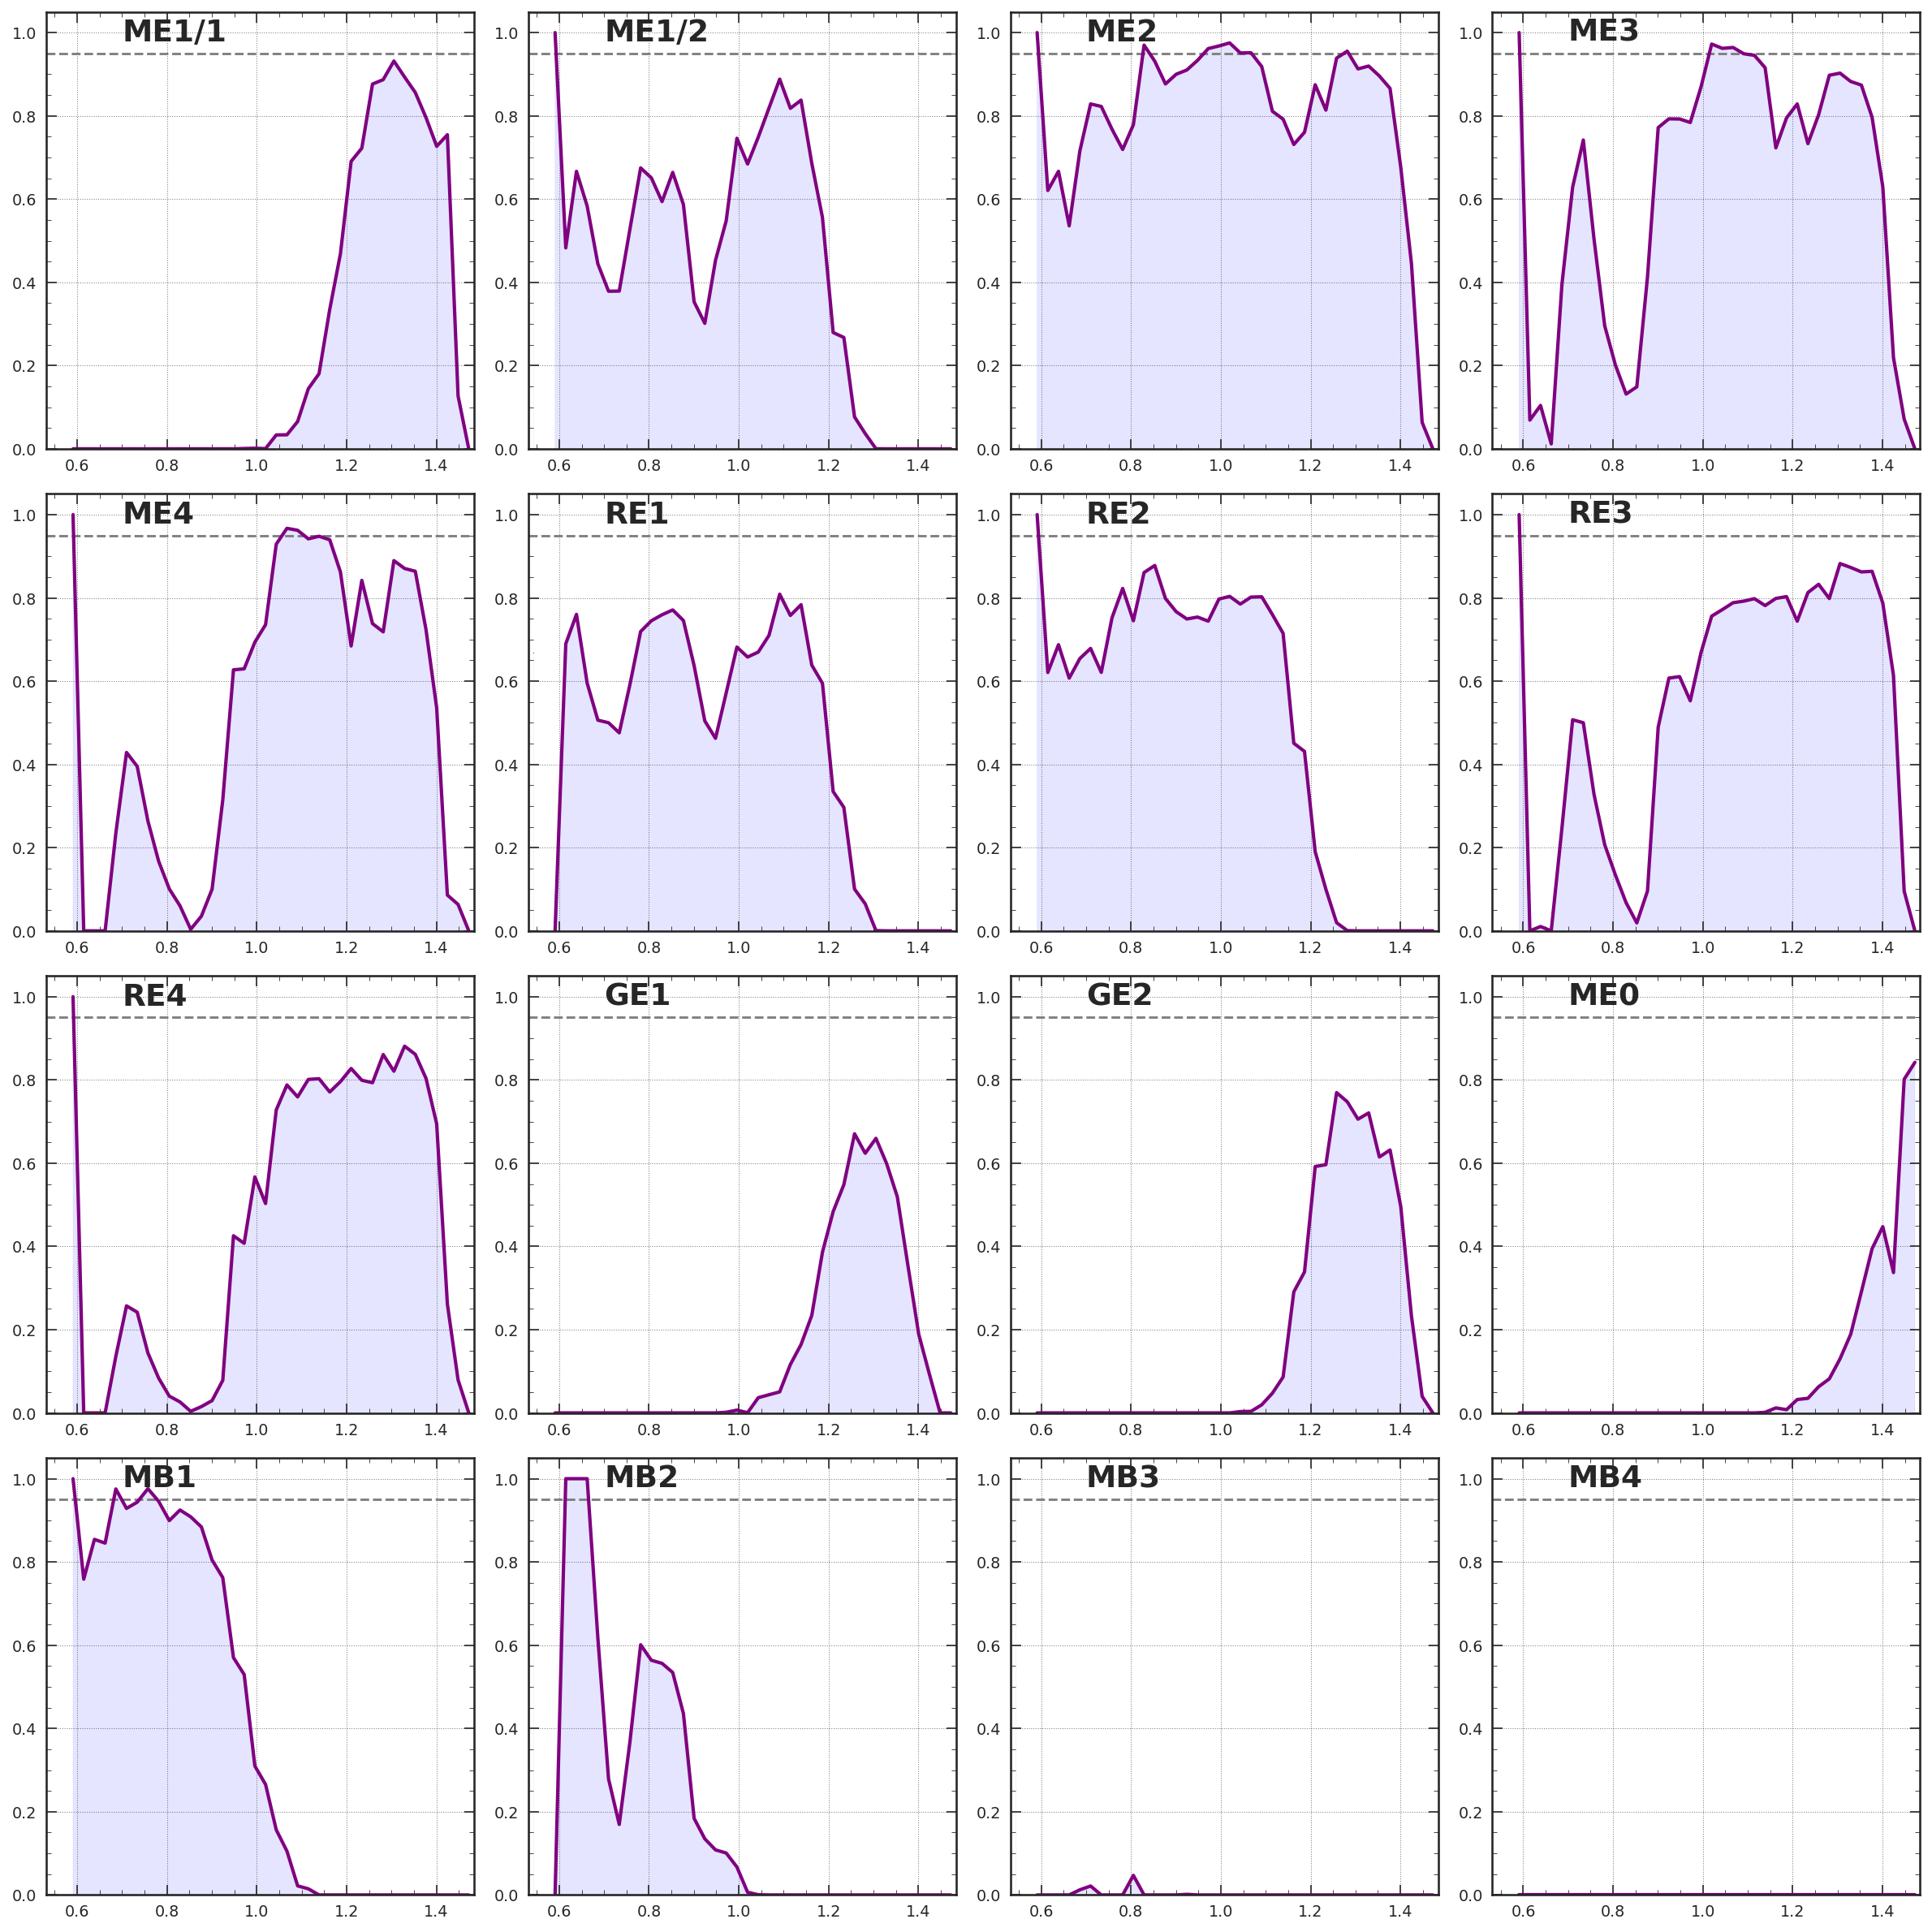

In [14]:
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

# xmin, xmax = 0.7, 3.0 # Eta/etastar bounds
# xmin, xmax = -150.0, 150.0 # d0 bounds
# xmin, xmax = -0.5, 0.5 # pT bounds
ymin, ymax = 0.0, 1.05 # Efficiency bounds
nbinsx = 40

# uncut_data = pt_cut_d0.copy()

for i in xrange(nlayers):
#   xdata = pt_cut_eta.copy()
  x_mask = pt_cut_hits.copy().astype(np.bool)
  mask = x_mask[...,i]
  valid = ~mask
#   xdata = pt_cut_etastar[:,i].copy()
  xdata = np.arctan(np.divide(deltar[:,i],deltaz))
  xmin, xmax = min(xdata),max(xdata)
#   xdata = out_part_invpt
#   xdata, maskdata, v = create_station_data(i,uncut_data)
  denom_hist, edges = np.histogram(xdata, bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(xdata[valid], bins=nbinsx, range=(xmin,xmax))
  
#   if i > 11:
#     mask = x_mask[...,i]
#     valid = ~mask  # valid hits
#     denom_hist, edges = np.histogram(uncut_data, bins=nbinsx, range=(xmin,xmax))
#     num_hist, edges = np.histogram(uncut_data[valid], bins=nbinsx, range=(xmin,xmax))

  eff_hist = np.true_divide(num_hist, denom_hist)

  xdata = (edges[1:] + edges[:-1])/2
  ydata = eff_hist
#   ydata = num_hist

  ax = axs[i/4,i%4]
  ax.text(0.7,0.98,stations[i],weight='bold',fontsize=18)
  ax.errorbar(xdata, ydata, color='purple', marker=',', capsize=0, lw=2)
  ax.fill_between(xdata, 0, ydata, color='blue', alpha=0.1)

  
#   for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
#     ax.plot([x,x], [ymin,ymax], '--', color='grey')
  for y in [0.95]:  # horizontal lines
    ax.plot([xmin,xmax], [y,y], '--', color='grey')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)
#   ax.set_ylabel('d0')
#   ax.set_xlabel('etastar')

plt.show()

# 2D Histogram

In [ ]:
# Define variables
y_eta = out_part_eta.copy()
y_pt = out_part_pt.copy()
y_invpt = out_part_invpt.copy()
x_mask = out_hits.copy().astype(np.bool)
if status == 'displaced':
  y_etastar = out_part_etastar.copy()
  y_d0 = out_part_d0.copy()
  y_r_vtx = out_part_r_vtx.copy()
  y_signed_rvtx = out_part_signed_rvtx.copy()
  y_etastar_corr = out_part_etastar_corr.copy()
  y_rvtx_corr = out_part_signed_rvtx_corr.copy()

In [ ]:
def my_hist2d(eff_hist, xedges, yedges, ax, cmap=None, colorbar=False):
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = eff_hist.T.ravel()
  h, edges, yedges, image = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=cmap, vmin=0.0, vmax=1.05)
  if colorbar:
    cb = plt.colorbar(image, ax=ax)#, norm=mpl.colors.Normalize(vmin=0.0, vmax=1.0),extend='both')
  return h, edges, yedges, image

# 2d Plots

In [ ]:
# 2d efficiency plots

# Define figure and create 4 by 4 subplots (16 stations)
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

# Which variables would you like to plot?
# xdata = no_pt_cut_etastar_corr
# ydata = no_pt_cut_invpt
# rangeshape = [[0.0,3.0],[-150.0,150.0]]
rangeshape = [[0.0,3.0],[-0.5,0.5]]
xbins, ybins = 40, 20

# d0_mask = np.zeros(len(out_part_eta), dtype=np.int32)

# for ievt,evt in enumerate(y_d0):
#         if abs(evt) <= 5:
#             d0_mask[ievt] = 1
# d0_mask = d0_mask.astype(bool)

# xdata_d0 = xdata[d0_mask]
# ydata_d0 = ydata[d0_mask]
# x_mask_d0 = x_mask[d0_mask]


# # Some presets:
# if status == 'prompt':
#     xmin, xmax = 0.7, 3.0

for i in xrange(nlayers):

#     xdata = pt_cut_etastar_corr[...,i]
    xdata = out_part_eta.copy()
    ydata = out_part_invpt.copy()
    x=out_part_eta[~out_hits[:,i].astype(np.bool)]
    y=out_part_invpt[~out_hits[:,i].astype(np.bool)]
#     ydata = pt_cut_signed_rvtx_corr[...,i]
#     ydata = no_pt_cut_invpt
#     x_mask = no_pt_cut_hits.astype(np.bool)
    x_mask = out_hits.copy()
    
    mask = x_mask[...,i]
    valid = ~mask  # valid hits

    # 2d histograms
#     num_hist, xedges, yedges = np.histogram2d(xdata_denom[:,i], ydata_denom, bins=(xbins,ybins), range=rangeshape)
#     denom_hist, xedges, yedges = np.histogram2d(xdata_num[:,i], ydata_num, bins=(xbins,ybins), range=rangeshape)
    denom_hist, xedges, yedges = np.histogram2d(xdata, ydata, bins=(xbins,ybins), range=rangeshape)
    num_hist, xedges, yedges = np.histogram2d(x, y, bins=(xbins,ybins), range=rangeshape)
    eff_hist = np.where(denom_hist != 0, np.true_divide(num_hist, denom_hist), 0)

    # Styling
    from matplotlib.colors import ListedColormap
    my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
    my_cmap.set_under('w',1)

    ax = axs[i/4,i%4]
    _ = my_hist2d(eff_hist, xedges, yedges, ax=ax, cmap=plt.cm.get_cmap('Greens'), colorbar=True) # 2d hist
    ax.text(rangeshape[0][0],rangeshape[1][1],stations[i],weight='bold',fontsize=18) # 1d and 2d hist

    for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
        ax.plot([x,x], [rangeshape[1][0],rangeshape[1][1]], '--', color='grey')
plt.show()

In [ ]:
out_part_eta.shape

In [ ]:
x=out_part_eta[out_hits[:,1].astype(np.bool)]

In [ ]:
y=out_part_invpt[out_hits[:,1].astype(np.bool)]

In [ ]:
plt.hist2d(x,y)

In [ ]:
# 2d efficiency plots

# Define figure and create 4 by 4 subplots (16 stations)
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

rangeshape = [[0.0,3.0],[-150.0,150.0]]
xbins, ybins = 40, 20

# Some presets:
if status == 'prompt':
    xmin, xmax = 0.7, 3.0

for i in xrange(nlayers):

    xdata = y_eta
    ydata = y_rvtx_corr[:,i]
    x_mask = pt_cut_hits.astype(np.bool)
    mask = x_mask[...,i]
    valid = ~mask
    
    # 2d histograms
    denom_hist, xedges, yedges = np.histogram2d(xdata, ydata, bins=(xbins,ybins), range=rangeshape)
    num_hist, xedges, yedges = np.histogram2d(xdata[valid], ydata[valid], bins=(xbins,ybins), range=rangeshape)
    eff_hist = np.where(denom_hist != 0, np.true_divide(num_hist, denom_hist), 0)

    # Styling
    from matplotlib.colors import ListedColormap
    my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
    my_cmap.set_under('w',1)

    ax = axs[i/4,i%4]
    _ = my_hist2d(_hist, xedges, yedges, ax=ax, cmap=plt.cm.get_cmap('Greens'), colorbar=True) # 2d hist
    ax.text(rangeshape[0][0],rangeshape[1][1],stations[i],weight='bold',fontsize=18) # 1d and 2d hist

    for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
        ax.plot([x,x], [rangeshape[1][0],rangeshape[1][1]], '--', color='grey')
plt.show()

In [ ]:
## 2d efficiency (1/pT vs. eta and etastar) binned in d0

eff_mode = 'etastar'

d0_mask = np.zeros((len(out_part_eta),4), dtype=np.int32)

for ievt,evt in enumerate(y_d0):
        if abs(evt) <= 20:
            d0_mask[ievt,0] = 1
        elif abs(evt) > 20 and abs(evt) <= 50:
            d0_mask[ievt,1] = 1
        elif abs(evt) > 50 and abs(evt) <= 100:
            d0_mask[ievt,2] = 1
        elif abs(evt) > 100 and abs(evt) <= 150:
            d0_mask[ievt,3] = 1
            
d0_mask = d0_mask.astype(bool)

print_statement = ['0 < d0 < 20', '20 < d0 < 50', '50 < d0 < 100', '100 < d0 < 150']

for d in xrange(4):
    fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)
    xdata = y_etastar[d0_mask[:,d]]
    ydata = y_invpt[d0_mask[:,d]]
#     ydata = y_signed_rvtx[d0_mask[:,d]]
    x_mask_c = x_mask[d0_mask[:,d]]
    print xdata.shape, ydata.shape, x_mask_c.shape
    print print_statement[d]
    for i in xrange(nlayers):
        if eff_mode == 'eta' or eff_mode == 'etastar':
            xmin, xmax = 0.7, 3.0
        elif eff_mode == 'd0':
            xmin, xmax = 0.0, 5.0
        nbinsx = 40

        rangeshape = [[0.7,3.0],[-0.5,0.5]]

        mask = x_mask_c[...,i]
        valid = ~mask  # valid hits

    #     # 1d histograms
    #     denom_hist, edges = np.histogram(np.abs(y_etastar), bins=40, range=[0.7,3.0])
    #     num_hist, edges = np.histogram(np.abs(y_etastar)[valid], bins=40, range=[0.7,3.0])
    #     eff_hist = np.where(denom_hist != 0, np.true_divide(num_hist, denom_hist), 0)
    #     ydata = eff_hist
    #     xdata = (edges[1:] + edges[:-1])/2

        # 2d histograms
        denom_hist, xedges, yedges = np.histogram2d(np.abs(xdata), ydata, bins=(40,20), range=rangeshape)
        num_hist, xedges, yedges = np.histogram2d(np.abs(xdata)[valid], ydata[valid], bins=(40,20), range=rangeshape)
    #     eff_hist = np.true_divide(num_hist, denom_hist)
        eff_hist = np.where(denom_hist != 0, np.true_divide(num_hist, denom_hist), 0)

    #     if i == 2:
    #         print eff_hist

        # Styling
        from matplotlib.colors import ListedColormap
        my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
        my_cmap.set_under('w',1)


        ax = axs[i/4,i%4]
        _ = my_hist2d(eff_hist, xedges, yedges, ax=ax, cmap=plt.cm.get_cmap('Greens'), colorbar=True) # 2d hist
        ax.text(0.7,rangeshape[1][1],stations[i],weight='bold') # 1d and 2d hist
    
        for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
            ax.plot([x,x], [rangeshape[1][0],rangeshape[1][1]], '--', color='grey')
    plt.show()
# #     for y in [0.95]:  # horizontal lines
# #         ax.plot([xmin,xmax], [y,y], '--', color='grey')
#     ax.set_xlim(etamin,etamax)
#     ax.set_ylim(ymin,ymax)



In [ ]:


if status == 'displaced':
    n = [0.0,20.0,50.0,100.0,150.0]
    titles = ['0 < d0 < 20','20 < d0 < 50','50 < d0 < 100','100 < d0 < 150']

    colors = ['blue','orange','green','red']

    for num in range(4):
        fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)
#         fig.suptitle(titles[num],fontsize=20,y=1.02)

        y_eta = new_out_part[num+1,0].copy()
        x_mask = new_out_hits[num+1,0].copy().astype(np.bool)

        for i in xrange(nlayers):
          if eff_mode == 'd0':
              xmin, xmax = n[num], n[num+1]
          elif eff_mode == 'eta' or eff_mode == 'etastar':
              xmin, xmax = 0.7, 3.0
          ymin, ymax = 0, 1.05

          mask = x_mask[...,i]
          valid = ~mask  # valid hits

          denom_hist, edges = np.histogram(np.abs(y_eta), bins=nbinsx, range=(xmin,xmax))
          num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=nbinsx, range=(xmin,xmax))
          eff_hist = np.true_divide(num_hist, denom_hist)

          xdata = (edges[1:] + edges[:-1])/2
          ydata = eff_hist

          ax = axs[i/4,i%4]
          if eff_mode == 'd0':
              ax.text(n[num]+0.85,0.98,stations[i],weight='bold')
          elif eff_mode == 'eta' or eff_mode == 'etastar':
              ax.text(0.85,0.98,stations[i],weight='bold')
          ax.errorbar(xdata, ydata, marker=',', capsize=0, lw=2,color=colors[num])
          ax.fill_between(xdata, 0, ydata, color=colors[num], alpha=0.2)

          ax.set_xlim(xmin,xmax)
          ax.set_ylim(ymin,ymax)

          if eff_mode == 'eta' or eff_mode == 'etastar':
              for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
                ax.plot([x,x], [ymin,ymax], '--', color='grey')
              for y in [0.95]:  # horizontal lines
                ax.plot([xmin,xmax], [y,y], '--', color='grey')
              ax.set_xlim(xmin,xmax)
              ax.set_ylim(ymin,ymax)
            
        plt.show()
        

In [ ]:
if status == 'displaced':
    fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

    a = 0.05
    
    if eff_mode == 'd0':
        xmin, xmax = 0, 150.0
    elif eff_mode == 'eta' or eff_mode == 'etastar':
        xmin, xmax = 0.7, 3.0
    ymin, ymax = 0, 1.05

    for num in range(4):

        if num == 0:
            y_eta = out_part1.copy()
            x_mask = out_hits1.copy().astype(np.bool)
        elif num == 1:
            y_eta = out_part2.copy()
            x_mask = out_hits2.copy().astype(np.bool)
        elif num == 2:
            y_eta = out_part3.copy()
            x_mask = out_hits3.copy().astype(np.bool)
        elif num == 3: 
            y_eta = out_part4.copy()
            x_mask = out_hits4.copy().astype(np.bool)




        for i in xrange(nlayers):

          mask = x_mask[...,i]
          valid = ~mask  # valid hits

          denom_hist, edges = np.histogram(np.abs(y_eta), bins=nbinsx, range=(xmin,xmax))
          num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=nbinsx, range=(xmin,xmax))
          eff_hist = np.true_divide(num_hist, denom_hist)

          xdata = (edges[1:] + edges[:-1])/2
          ydata = eff_hist

          ax = axs[i/4,i%4]
          ax.text(0.85,0.98,stations[i],weight='bold')
          ax.errorbar(xdata, ydata, marker=',', capsize=0, lw=2)
          ax.fill_between(xdata, 0, ydata, alpha=a)

          ax.set_xlim(xmin,xmax)
          ax.set_ylim(ymin,ymax)
          ax.legend([num+1])
        
          for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
            ax.plot([x,x], [ymin,ymax], '--', color='grey')
          for y in [0.95]:  # horizontal lines
            ax.plot([xmin,xmax], [y,y], '--', color='grey')
          ax.set_xlim(xmin,xmax)
          ax.set_ylim(ymin,ymax)

    plt.show()